In [1]:
import pandas as pd 
import numpy as np
#from sklearn import linear_model
#import seaborn as sns
#import matplotlib.pyplot as plt
#from sklearn import preprocessing
from itertools import groupby
import common
from os import listdir
from os.path import isfile, join

In [2]:
import asset
import backtest

In [ ]:
lenRecord = pd.read_csv('record.txt', header=False)
end = lenRecord[1]
start = np.hstack((0, end[:-1]))
df_record = pd.concat([lenRecord, pd.DataFrame({'start': start})], axis=0)

In [3]:
p_stock_id = '股票交易代码'
p_stock_title = '股票名称'
p_cash_divid_bt = '税前派现金额（人民币）（元）（1：X）'
p_date = '除权日'
p_cash_divid_at = '税后派现金额（人民币）（元）（1：X）'
p_stock_divid_rat = '送股比例（1：X）'
p_increa_trans_rat = '转增比例（1：X）'
p_reser_rat = '送转比例（1：X）'
p_allot_prc = '配股价格（元）'
p_allot_rat = '实际配股比例'

In [62]:
STOCK_LIST = ['000002']#, '000099', '000004', '000005', '000006', '399300'] 

In [5]:
id_ = '603993'

In [71]:
# read all the tech data of stock 000001
def read_tech(path = '/home/lcc/sensequant/kline_5minute/sz/'):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    df_tech = None
    for f in files:

        date = f.split('.')[0]
        df = pd.read_csv(path+f, dtype={'stock_id': str})
        df = df[df['stock_id'].isin(STOCK_LIST)]
        df['date'] = date
        if df_tech is None:
            df_tech = df
        else:
            df_tech = pd.concat([df_tech, df])
    df_tech['date'] = pd.to_datetime(df_tech.date)
    return df_tech

In [72]:
def read_panel(fname='/home/lcc/sensequant/kline_5minute/stock_info'):
    df_panel = pd.read_csv(fname)
    df_panel = df_panel[(df_panel[p_stock_id].isin(STOCK_LIST))]
    df_panel[p_date] = pd.to_datetime(df_panel[p_date])
    return df_panel


In [73]:
df_tech = read_tech()
df_tech[['high', 'low', 'open', 'close']] = df_tech[['high', 'low', 'open', 'close']].apply(lambda x: x/1000)
# set index
l = [n for n in range(len(df_tech))]
df_tech = df_tech.set_index([l])
df_panel = read_panel()
df_panel = df_panel[(df_panel[p_reser_rat]!='\\N')]

In [111]:
# %load ml_model.py
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Dropout
from keras.regularizers import l2
import pandas as pd
import numpy as np
from sklearn import linear_model, preprocessing
from sklearn.metrics import classification_report

class ALGORITHM():
    def __init__(self):
        return

    def prepare_data(self, trainFname='train.txt', testFname='test.txt'):
        trainData = np.loadtxt('train.txt')
        testData = np.loadtxt('test.txt')
        (X_train, Y_train) = (trainData[:, :-1], trainData[:, -1])
        (X_test, Y_test) = (testData[:, :-1], testData[:, -1])
        return (X_train, Y_train, X_test, Y_test)

    def preprocess_X(self, X):
        return preprocessing.scale(X)

    def preprocess_Y(self, Y):
        Y_ = np.zeros((len(Y), 3))
        msk1 = Y==0
        msk2 = Y==1
        msk3 = Y==2
        Y_[msk1, 0] = 1
        Y_[msk2, 1] = 1
        Y_[msk3, 2] = 1
        return Y_

    def train(self, X_train, Y_train, X_test):
        '''
        output: predicted class: 0, 1, 2
        '''
        inputs = Input(shape=(12,))
        x = Dense(24, activation='relu', W_regularizer=l2(0.01))(inputs)
        drop = Dropout(0.2)(x)
        prediction = Dense(3, activation='softmax', W_regularizer=l2(0.01))(drop)
        model = Model(input=inputs, output=prediction)
        model.compile(optimizer='adadelta',
                      loss='categorical_crossentropy')
        model.fit(X_train, Y_train, nb_epoch=100)
        pred = model.predict(X_test)
        return (np.argmax(pred, axis=1),
                np.max(pred, axis=1))

    def benchmark(self, X_train, Y_train, X_test):
        '''
        output: predicted class: -1, 0, 1
        '''
        lr = linear_model.LogisticRegression()
        model = lr.fit(X_train, Y_train)
        return (model.predict(X_test),
                np.max(model.predict_proba(X_test), axis=1))

    def evaluate(self, Y_pred, Y_true, method, fname='result.txt'):
        if method != 'NN' and method != 'LR':
            return ValueError('method just can be either NN or LR') 
        with open(fname, 'w+') as f:
            f.write(\
                    method\
                    + ':\n'\
                    + classification_report(Y_pred, Y_true)\
                    + '\n')
        msk = Y_pred == Y_true
        return msk.cumsum()[-1]/len(msk)

    def combine_to_df(self, class_, prob):
        return pd.DataFrame({'class_': class_, 'prob': prob})

    def run(self):
        X_train, Y_train, X_test, Y_test = self.prepare_data()
        X_train_scale, X_test_scale = (self.preprocess_X(X_train), self.preprocess_X(X_test))
        Y_train_matrix, Y_test_matrix = (self.preprocess_Y(Y_train), self.preprocess_Y(Y_test))
        predNN = self.train(X_train_scale, Y_train_matrix, X_test_scale)
        predLR = self.benchmark(X_train_scale, Y_train, X_test_scale)
        self.combine_to_df(predNN[0], predNN[1])\
                                                .to_csv('predict_NN', index=False)
        self.combine_to_df(predLR[0], predLR[1])\
                                                .to_csv('predict_LR', index=False)

        accNN = self.evaluate(predNN[0], np.argmax(Y_test_matrix, axis=1), 'NN')
        accLR = self.evaluate(predLR[0], Y_test, 'LR')
        print ('NN accuracy: ', accNN)
        print ('LR accuracy: ', accLR)
        return 

In [268]:
df4test = pd.read_csv('cache.txt')
df4test = df4test.drop('index', axis=1)
#algorithm = ALGORITHM()
#algorithm.run()

,stock_id,date,high,low,open,close
0,000001,2016-01-04,3538.437,11.300,12.000,3296.258
1,000001,2016-01-05,3327.856,11.170,11.270,3287.710
2,000001,2016-01-06,3362.973,11.390,11.420,3361.840
3,000001,2016-01-07,3309.656,10.909,11.409,3125.001
4,000001,2016-01-08,3235.450,10.909,11.210,3186.412
5,000001,2016-01-11,3166.215,10.699,11.000,3016.703
6,000001,2016-01-12,3047.625,10.649,10.829,3022.861
7,000001,2016-01-13,3058.754,10.710,10.890,2949.596
8,000001,2016-01-14,3012.292,10.500,10.590,3007.648
9,000001,2016-01-15,3001.413,10.430,10.659,2900.969


In [279]:
df4test = pd.read_csv('cache.txt')
df4test = df4test.drop('index', axis=1)
lenRecord = pd.read_csv('record.txt', header=None, sep='\t', dtype={0:str})
lenRecord[1] = lenRecord[1].cumsum()

start = np.hstack((0, lenRecord[1][:-1]))


df_record = pd.concat([lenRecord, pd.DataFrame({'start': start})], axis=1, ignore_index=True)
df_record = df_record.rename(columns={0: 'stock_id', 1: 'end', 2: 'start'})

predLR = pd.read_csv('predict_LR')
predNN = pd.read_csv('predict_NN')
df4test['prob'] = np.nan
df4test['class_'] = np.nan
for row in df_record.iterrows():
    row = row[1]
    t = predNN[row.start: row.end]
    t = t.append({'prob': np.nan, 'class_': np.nan}, ignore_index=True)
    
    msk = df4test.stock_id==row.stock_id
    df4test.loc[msk, 'prob'] = t['prob'].values
    df4test.loc[msk, 'class_'] = t['class_'].values

In [350]:
df4test = pd.read_csv('cache/cache.txt', dtype={'stock_id': str})


In [329]:
hs300_weight = reader.read_dict(fname='data/weight.txt', symbol=',')
stocks = list(hs300_weight.keys())


In [348]:
l = [12, 123, 32, 10]
np.shape(np.array(l))

(1, 4)

In [303]:
from read_stock import READ_DATA
reader = READ_DATA('000001')
hs300_weight = reader.read_dict(fname='data/weight.txt', symbol=',')

In [298]:
diu = df4test.loc[df4test.stock_id=='000728', 'prob'].values[:-1]
predNN[3564: 3668]['prob'].values - diu

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [353]:
dict_ = {}
with open('data/weight.txt') as f:
    for line in f:
        line = line.rstrip()
        line = line.split(',')
        if line[0] in df4test.stock_id:
            dict_[line[0]] = float(line[1])
        else: 
            continue
dict_ 

{}

In [360]:
'000001' in df4test['stock_id'].values

True

In [366]:
if 3 * df4test[(df4test.stock_id=='000001')&(df4test.date=='2016-01-04')].open.values > 30:
    print ('yes')

yes


In [163]:
lenRecord = pd.read_csv('record.txt', header=None, sep='\t', dtype={0:str})
lenRecord[1] = lenRecord[1].cumsum()

start = np.hstack((0, lenRecord[1][:-1]))
#pd.DataFrame({'start': start})

df_record = pd.concat([lenRecord, pd.DataFrame({'start': start})], axis=1, ignore_index=True)
df_record = df_record.rename(columns={0: 'stock_id', 1: 'end', 2: 'start'})
df_record

,stock_id,end,start
0,000001,104,0
1,000002,208,104
2,000009,312,208
3,000027,416,312
4,000039,520,416
5,000046,624,520
6,000060,728,624
7,000061,832,728
8,000063,936,832
9,000069,1040,936


In [22]:
def adjust_price(price, cash_divid_at, reser_rat):
    return (price - float(cash_divid_at)) / (1 + float(reser_rat))

In [23]:
df_copy = df_tech.copy()
df = df_panel[[p_stock_id, p_cash_divid_bt, p_cash_divid_at, p_reser_rat, p_date]]
for values in df.itertuples():
    stock_id = values[1]
    cash_divid_bt = values[2]
    cash_divid_at = values[3]
    reser_rat = values[4]
    #print (reser_rat)
    date = values[5]
    if cash_divid_bt != '\\N':
        c = cash_divid_at
    elif cash_divid_at != '\\N':
        c = cash_divid_bt
    else:
        c = 0
    criteria = (df_copy['stock_id'] == stock_id) & (df_copy['date'] < date)
    df_copy.loc[criteria, ['high', 'low', 'open', 'close']] = df_copy[criteria][['high', 'low', 'open', 'close']].apply(adjust_price, args=(c, reser_rat,))
    


In [24]:
groups = df_copy.groupby(['stock_id', 'date'])
col = ['stock_id', 'date', 'high', 'low', 'open', 'close']
df_y = pd.DataFrame()
for name, group in groups:
    if group.high.max() <= 0:
        continue
    stock_id = name[0]
    date = name[1]
    high = group.high.max()
    low = group[group['low']>0].low.min()
    open_ = group[(group['open'].astype(np.float))>0].iloc[0]['open']
    close = group.iloc[-1]['close']
    row = pd.Series([stock_id, date, high, low, open_, close])
    df_y = df_y.append(row, ignore_index=True)
df_y.columns = col

In [25]:
record = pd.read_csv('/home/lcc/helloworld/code/record.txt', sep='\t', dtype={'stock_id': str})


OSError: File b'/home/lcc/helloworld/code/record.txt' does not exist

In [155]:
predict = np.loadtxt('lepredict')
len(predict)

11415

In [237]:
df_all = pd.DataFrame()
path='/home/lcc/helloworld/code/cache/'
files = [f for f in listdir(path) if isfile(join(path, f))]
for f in files[1:5]:
    df = pd.read_csv(path+f)
df

,index,stock_id,date,high,low,open,close
0,146,46,2016-01-04,12.649,11.319,12.550,11.350
1,147,46,2016-01-05,11.439,10.560,10.899,11.130
2,148,46,2016-01-06,11.529,11.010,11.170,11.390
3,149,46,2016-01-07,11.119,10.250,11.119,10.270
4,150,46,2016-01-08,10.670,9.899,10.670,10.170
5,151,46,2016-01-11,10.180,9.489,10.000,10.069
6,152,46,2016-01-12,10.210,10.000,9.949,10.000
7,153,46,2016-01-13,10.149,9.850,10.020,9.890
8,154,46,2016-01-14,10.100,9.500,9.699,10.060
9,155,46,2016-01-15,10.149,9.619,10.029,9.750


# Construct the Indicator 

In [44]:
p_exchange_ = '交易所简称'
p_stock_id_ = '股票代码'
p_date_ = '时间'
p_earn_per_share_ = '每股收益(元)'
p_bvps_ = '每股净资产(元)'
p_roe_ = '净资产收益率(％)'
p_net_profit_ = '净利润(万元)'
p_npgr_ = '净利润增长率(%)'
p_wroe_ = '加权净资产收益率(%)'
p_asset_liability_ratio_ = '资产负债比率(%)'
p_cash_in_net_profit_ = '净利润现金含量(%)'
p_basic_earn_per_share_ = '基本每股收益(元)'
p_net_earn_per_share_ = '每股收益-扣除(元)'
p_dulute_earn_per_share_ = '每股收益-摊薄(元)'
p_capital_reserve_per_share_ = '每股资本公积金(元)'
p_udpps_ = '每股未分配利润(元)'
p_epcf_ = '每股经营现金流量(元)'
p_operating_net_cash_flow_ = '经营活动现金净流量增长率(%)'
p_equity_ = '总股本(亿股)'
p_limit_equity_ = '限售股份(亿股)'
p_a_share_ = '流通A股(亿股)'

In [149]:
STOCK300 = [line.rstrip() for line in open('hushen_300_.txt')]
STOCK500 = [line.rstrip() for line in open('zhongzheng_500_.txt')]
STOCK800 = STOCK300+STOCK500

In [38]:
df = pd.read_excel('000300closeweight.xls', 'sheet1', converters={'Constituent Code': str})
df = df[['Constituent Code', 'Weight(%)']]
df.to_csv('data/weight.txt', index=False)

In [40]:
df_finance = pd.read_csv('/home/lcc/sensequant/kline_5minute/stock_finance.txt', dtype={p_stock_id_: str})
df_finance = df_finance.drop('每股净资产(元).1', 1)
df_finance = df_finance[df_finance[p_stock_id_].isin(STOCK_LIST)].reset_index(drop=True)
df_finance[p_date_] = pd.to_datetime(df_finance[p_date_])
df_finance['year'] = df_finance[p_date_].apply(lambda time: time.year)
df_finance['month'] = df_finance[p_date_].apply(lambda time: time.month)
df_finance['day'] = df_finance[p_date_].apply(lambda time: time.day)
df_finance

,交易所简称,股票代码,股票名称,时间,每股收益(元),每股净资产(元),净资产收益率(％),净利润(万元),净利润增长率(%),加权净资产收益率(%),...,基本每股收益(元),每股收益-扣除(元),每股收益-摊薄(元),每股资本公积金(元),每股未分配利润(元),每股经营现金流量(元),经营活动现金净流量增长率(%),year,month,day
0,SH,603993,洛阳钼业,2016-03-31,0.0100,1.0407,0.8028,13466.73,-53.829995,0.81,...,0.0100,NaN,0.008355,0.634819,0.185233,0.0157,435.358139,2016,3,31
1,SH,603993,洛阳钼业,2015-12-31,0.0500,1.0276,4.3862,70310.84,-60.942803,4.77,...,0.0500,0.0500,0.045073,0.634819,0.176878,0.0805,-62.620239,2015,12,31
2,SH,603993,洛阳钼业,2015-09-30,0.1231,3.0754,3.7022,59835.36,-58.618774,4.22,...,0.1231,NaN,0.113859,2.304456,0.523690,0.2977,-7.339191,2015,9,30
3,SH,603993,洛阳钼业,2015-06-30,0.0900,2.7621,3.2584,43749.59,-55.957194,3.15,...,0.0900,0.0900,0.090000,1.935315,0.538414,0.2428,0.423252,2015,6,30
4,SH,603993,洛阳钼业,2015-03-31,0.0200,2.9222,2.0529,29167.71,-21.335104,2.08,...,0.0200,NaN,0.059992,1.877373,0.714068,-0.0156,-115.863192,2015,3,31
5,SH,603993,洛阳钼业,2014-12-31,0.1200,2.8828,12.4662,180020.18,65.930855,14.39,...,0.1200,0.0900,0.359376,1.877373,0.654076,0.7161,165.000295,2014,12,31
6,SH,603993,洛阳钼业,2014-09-30,0.2886,2.5819,11.1788,144595.42,73.645192,11.63,...,0.2886,0.2137,0.288625,1.596278,0.583325,0.3562,64.325804,2014,9,30
7,SH,603993,洛阳钼业,2014-06-30,0.2000,NaN,NaN,99334.24,79.118063,8.00,...,0.2000,0.1400,0.197961,1.596278,0.492661,0.2451,16.939789,2014,6,30
8,SH,603993,洛阳钼业,2014-03-31,0.0700,2.4979,2.9757,37078.43,83.097393,3.04,...,0.0700,NaN,0.074332,1.596278,0.509031,0.0981,34.469100,2014,3,31
9,SH,603993,洛阳钼业,2013-12-31,0.2300,2.3991,9.6418,108491.08,6.743091,9.88,...,0.2300,0.1900,0.231317,1.596278,0.434700,0.2702,-14.597035,2013,12,31


In [60]:

def select_val_b4_date(df, date, dateCol, valCol):
    # default: the column of the date in the df is dateCol
    lb = np.max(df[df[dateCol]<date][dateCol])
    return df[df[dateCol]==lb][valCol].values

In [61]:
select_val_b4_date(df_finance, pd.to_datetime('2016-02-02'), p_date_, p_exchange_)

array(['SH'], dtype=object)

In [ ]:
df_finance[df_finance[dateCol<date]

In [42]:
df_share = pd.read_csv('/home/lcc/sensequant/kline_5minute/stock_share.txt', dtype={p_stock_id_: str})
df_share = df_share[df_share[p_stock_id_].isin(STOCK_LIST)]
df_share[p_date_] = pd.to_datetime(df_share[p_date_])
df_share

,交易所简称,股票代码,股票名称,时间,总股本(亿股),限售股份(亿股),流通A股(亿股)
103579,SH,603993,洛阳钼业,2015-12-31,168.87,129.54,0.00
103580,SH,603993,洛阳钼业,2015-11-13,168.87,129.54,0.00
103581,SH,603993,洛阳钼业,2015-10-09,56.29,43.18,0.00
103582,SH,603993,洛阳钼业,2015-07-09,56.29,25.21,17.97
103583,SH,603993,洛阳钼业,2015-06-30,51.45,20.37,17.97
103584,SH,603993,洛阳钼业,2014-12-31,50.76,19.68,17.97
103585,SH,603993,洛阳钼业,2014-06-30,50.76,19.68,17.97
103586,SH,603993,洛阳钼业,2013-12-31,50.76,19.68,17.97
103587,SH,603993,洛阳钼业,2013-10-09,50.76,19.68,17.97
103588,SH,603993,洛阳钼业,2013-06-30,50.76,2.00,35.65


In [104]:
from common import scalify

In [121]:
df_y

,stock_id,date,high,low,open,close
0,000738,2015-06-01,43.98385,40.57385,41.18385,43.28385
1,000738,2015-06-02,44.98385,42.78385,43.49385,44.98385
2,000738,2015-06-03,44.76385,42.09385,44.76385,42.96385
3,000738,2015-06-04,42.93385,38.86385,42.93385,41.97385
4,000738,2015-06-05,43.96385,41.18385,43.08385,42.17385
5,000738,2015-06-08,41.98385,39.56385,41.98385,40.33385
6,000738,2015-06-09,41.46385,39.16385,39.98385,40.45385
7,000738,2015-06-10,40.97385,39.29385,39.98385,40.19385
8,000738,2015-06-11,41.36385,39.70385,40.11385,41.36385
9,000738,2015-06-12,41.98385,40.89385,41.48385,41.41385


In [123]:
def current_cashflow_ratio(df_y):
    return df_y[5:].apply(lambda row: scalify(row.close / select_val_b4_date(df_finance, row.date, p_epcf_)), axis=1)

In [125]:
current_cashflow_ratio(df_y)

5       -332.239292
6       -333.227759
7       -331.086079
8       -340.723641
9       -341.135502
10      -335.698929
11      -312.058072
12      -313.705519
13      -308.927924
14      -296.407331
15      -326.061367
16      -331.827430
17      -320.295305
18      -288.252471
19      -259.422158
20      -273.013591
21    -14201.833333
22    -12782.785714
23    -11501.833333
24    -10349.452381
25     -9316.119048
26     -8382.785714
27     -9220.880952
28    -10144.690476
29    -11158.976190
30    -12271.428571
31    -11042.857143
32    -11538.095238
33    -12690.476190
34    -13961.904762
           ...     
217     -241.124780
218     -237.161687
219     -236.028120
220     -235.413005
221     -243.752197
222     -241.212654
223     -245.685413
224     -232.952548
225     -222.847100
226     -222.231986
227     -219.771529
228     -217.750439
229     -218.796134
230     -220.202109
231     -219.244288
232     -216.871705
233     -217.302285
234     -220.114236
235     -220.474517


In [ ]:
df.apply(lambda row: row)

In [198]:
def lower_bound(val, df):
    return np.max(df[df[p_date_]<val][p_date_])

In [226]:
pe = df_y.apply(lambda row: scalify(row.close / df[df[p_date_]==lower_bound(row.date, df)]['eps_in_past_one_year'].values), axis=1)

In [237]:
pb = df_y.apply(lambda row: scalify(row.close \
                                    / df_bvps[\
                                              (df_bvps[p_date_]==lower_bound(row.date, df_bvps))\
                                              &(~df_bvps[p_bvps_].isnull())][p_bvps_].values)\
                , axis=1)

In [242]:
df_cash = df_finance[[p_stock_id_, p_stock_title, p_date_, p_epcf_]]
cashRatio = df_y.apply(lambda row: scalify(row.close / df_cash[df[p_date_]==lower_bound(row.date, df_cash)][p_epcf_].values), axis=1)
cashRatio

0      15.803598
1      15.674386
2      15.734022
3      16.270748
4      16.201173
5      17.185170
6      16.877050
7      16.578869
8      16.380082
9      16.409900
10     15.823477
11     15.545174
12     15.634629
13     15.525296
14     14.541298
15     14.859358
16     15.028327
17     14.779843
18     13.686512
19     13.477786
20     14.451844
21      1.090909
22      1.077586
23      1.024295
24      1.087774
25      1.148119
26      1.033699
27      1.117555
28      1.164577
29      1.131661
         ...    
221     2.557971
222     2.552899
223     2.574638
224     2.552899
225     2.579710
226     2.589372
227     2.589372
228     2.541063
229     2.500000
230     2.482850
231     2.504589
232     2.507246
233     2.500000
234     2.502174
235     2.487923
236     2.487923
237     2.475845
238     2.487923
239     2.482850
240     2.466184
241     2.470773
242     2.468599
243     2.480676
244     2.482850
245     2.548309
246     2.531159
247     2.526570
248     2.5362

In [245]:
assetRatio = df_y.apply(lambda row: scalify(df_finance[df_finance[p_date_]==lower_bound(row.date, df_finance)][p_asset_liability_ratio_].values), axis=1)


In [251]:
df_finance['average_asset_ratio_in_last_one_year'] = df_finance.apply(lambda row: np.average(df_finance.loc[row.name:row.name+4, p_asset_liability_ratio_].values), axis=1)
aveAssetRatio = df_y.apply(lambda row: scalify(df_finance[df_finance[p_date_]==lower_bound(row.date, df_finance)]['average_asset_ratio_in_last_one_year'].values), axis=1)

0      94.183041
1      94.183041
2      94.183041
3      94.183041
4      94.183041
5      94.183041
6      94.183041
7      94.183041
8      94.183041
9      94.183041
10     94.183041
11     94.183041
12     94.183041
13     94.183041
14     94.183041
15     94.183041
16     94.183041
17     94.183041
18     94.183041
19     94.183041
20     94.183041
21     94.127796
22     94.127796
23     94.127796
24     94.127796
25     94.127796
26     94.127796
27     94.127796
28     94.127796
29     94.127796
         ...    
221    93.743144
222    93.743144
223    93.743144
224    93.743144
225    93.743144
226    93.743144
227    93.743144
228    93.743144
229    93.743144
230    93.743144
231    93.743144
232    93.743144
233    93.743144
234    93.743144
235    93.743144
236    93.743144
237    93.743144
238    93.743144
239    93.743144
240    93.743144
241    93.743144
242    93.743144
243    93.743144
244    93.743144
245    93.743144
246    93.743144
247    93.743144
248    93.7431

In [259]:
circuMarketVal = df_y.apply(lambda row: scalify(row.close * df_share[df_share[p_date_]==lower_bound(row.date, df_share)][p_a_share_].values), axis=1)
circuMarketVal

0      398.29500
1      395.03850
2      396.54150
3      410.06850
4      408.31500
5      433.11450
6      425.34900
7      417.83400
8      412.82400
9      413.57550
10     398.79600
11     391.78200
12     394.03650
13     391.28100
14     366.48150
15     374.49750
16     378.75600
17     372.49350
18     344.93850
19     339.67800
20     364.22700
21     348.69600
22     344.43750
23     327.40350
24     347.69400
25     366.98250
26     330.40950
27     357.21300
28     372.24300
29     361.72200
         ...    
221    265.27950
222    264.75345
223    267.00795
224    264.75345
225    267.53400
226    268.53600
227    268.53600
228    263.52600
229    259.26750
230    257.48895
231    259.74345
232    260.01900
233    259.26750
234    259.49295
235    258.01500
236    258.01500
237    256.76250
238    258.01500
239    257.48895
240    216.04360
241    216.44564
242    216.25520
243    217.31320
244    217.50364
245    223.23800
246    221.73564
247    221.33360
248    222.180

In [ ]:
marketVal = df_y.apply(lambda row: scalify(row.close * df_share[df_share[p_date_]==lower_bound(row.date, df_share)][p_equity_].values), axis=1)


In [223]:
df_bvps = df_finance[[p_stock_id_, p_stock_title, p_date_, p_bvps_]]
df_bvps[df_bvps[p_bvps_].isnull()]

,股票代码,股票名称,时间,每股净资产(元)
7,000001,平安银行,2014-06-30,NaN
11,000001,平安银行,2013-06-30,NaN
15,000001,平安银行,2012-06-30,NaN
19,000001,平安银行,2011-06-30,NaN
23,000001,平安银行,2010-06-30,NaN
27,000001,平安银行,2009-06-30,NaN
74,000001,平安银行,1993-06-30,NaN
75,000001,平安银行,1992-12-31,NaN
76,000001,平安银行,1992-06-30,NaN
77,000001,平安银行,1991-12-31,NaN


In [378]:
N = 5
M = 9
U = 26

In [16]:
#df_y.loc[N:, 'x_1']
x_1 = df_y.loc[N:].apply(lambda row: slope_N_day(row['close'], df_y.loc[row.name-N,'close'], N), axis=1)

#df_y.loc[N:, 'x_2'] 
x_2 = df_y.loc[N:].apply(lambda row: percentile_N_day(row['close'],\
                                                      df_y.loc[row.name-N:row.name+1, 'high'].max(),\
                                                      df_y.loc[row.name-N:row.name+1, 'low'].min()\
                                                      ), axis=1)
x_4 = df_y.loc[N:].apply(lambda row: return_N_day(row.close, df_y.loc[row.name-N, 'close']), axis=1)

In [26]:
def cal_ema(df, M):
    mul = 2 / (M + 1)
    ema = np.full((len(df), 1), -np.inf)
    ema[0] = df.loc[0, 'close'] * mul
    for index in range(1, len(ema)):
        ema[index] = (df.loc[index, 'close'] - ema[index-1]) * mul \
                                  + ema[index-1]
    return ema

ema_M = cal_ema(df_y, M)
ema_U = cal_ema(df_y, U)
#x_3 = (ema_M - ema_U) / ema_U

In [278]:
a = np.array([3,2,3])
b = np.array([1,5,6])
np.vstack((a, b))

array([[3, 2, 3],
       [1, 5, 6]])

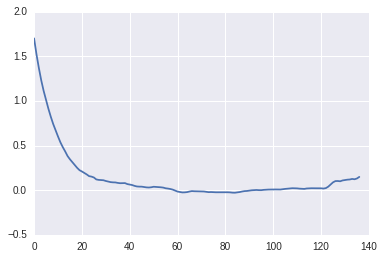

In [32]:
%matplotlib inline
plt.plot(df_y.ppo)

In [14]:
# fake data
n = len(df_y[df_y.close>14.3])
m = len(df_y[df_y.close<=14.3])
msk = df_y.close>14.3
df_y.loc[msk, 'down'] = np.random.uniform(0.3,1,[n])
df_y.loc[msk, 'up'] = 0
df_y.loc[~msk, 'down'] = 0
df_y.loc[~msk, 'up'] = np.random.uniform(0.3,1,[m])

In [265]:
a = np.array([1,2,3,4])
b = np.array([2,3,4,5])
a @ b

40

In [282]:
def read_weight(fname='data/weight.txt'):
    wdict = {}
    with open(fname) as f:
        for line in f:
            line = line.rstrip()
            wdict[line.split(',')[0]] = float(line.split(',')[1])
    return wdict 

In [306]:
def get_init_share(shareDict):
    min_ = min(list(shareDict.values()))
    for k, v in shareDict.items():
        shareDict[k] = v * 100 / min_
    return shareDict

In [317]:
df_x.loc[:, ['diu', 'ni']] = np.nan
df_x

KeyError: "['ni'] not in index"

# backtest

In [68]:
X = np.vstack((x_1, x_2, x_4)).T
X = X[:-1]

In [ ]:
# %load common.py
def scalify(l):
    if len(l) > 1:
        raise ValueError('Not only one element!')  
    else:
        return l[0]



In [571]:
#%%writefile asset.py
import pandas as pd 
import numpy as np 
import common

class ASSET():
    """
        
    """ 
    def __init__(self, df, cash=100000, upThreshold=0.5, downThreshold=0.5):
        self.df = df
        self.df_order = pd.DataFrame({'date': df[1:].date, \
                                      'prob': df[1:].apply(lambda row: row.up if row.up > row.down else row.down, axis=1), \
                                      'trend': df[1:].apply(lambda row: 1 if df.loc[row.name-1, 'close']<=14.3  else 0, axis=1)})
        self.df.loc[1:, 'trend'] = df[1:].apply(lambda row: 1 if df.loc[row.name-1, 'close']<=14.3  else 0, axis=1)
        self.df = self.df[1:]
        self.df.loc[:,'close'] = self.df.close.apply(lambda x: round(x, 2))
        self.df.loc[:,'open'] = self.df.open.apply(lambda x: round(x, 2))
        #df_order = df[(df.up>upThreshold)|(df.down>downThreshold)]
        #self.df_order = pd.DataFrame({'date': df_order.date, \
                                      #'prob': df_order.apply(lambda row: row.up if row.up > row.down else row.down, axis=1), \
                                      #'trend': df_order.apply(lambda row: 1 if row.up > row.down else 0, axis=1)})
        self._cash = cash 
        self._share = 0
        #self.assetRecord = np.array([self._cash])

#    def _prob_to_invest(self):
#        prob = self.df_order.prob.values
        # $10 for 1 prob
#        invest = prob * 10
#        return invest

    def _strategy(self, row, price):
        '''
            @row: trend, prob, date
        '''
        if row.trend == 1:
            # up
            invest = 100 * price
            if invest > self._cash:
                return(0, 0)
            share = common.scalify(invest/\
                                   self.df[self.df.date==row.date].open.values)
            return (invest, share)
        
        elif row.trend == 0:
            # down
            if self._share == 0:
                return (0, 0)
            invest = -self._share * price
            share = common.scalify(invest/\
                                   self.df[self.df.date==row.date].open.values)
            return (invest, share)
            
        else:
            raise ValueError('No this kind of trend!')

    def _new_strategy(self, row, price):
        if row.trend == 1:
            invest = 100 * price
            if invest > self._cash:
                return (0, 0)
            share = invest/row.open
            return (invest, share)
        elif row.trend == 0:
            if self._share == 0:
                return (0, 0)
            invest = -self._share * price
            share = invest / price
            return (invest, share)
        else:
            pass

    def _measure_asset_val(self, lastOrderDate, todate):
        '''
            measure the value of each row:
            @pro, @begin_date, @end_date
        '''
        # TODO: fix the data type bug
        #(self.df[(lastOrderDate<self.df.date)])
        return self._cash + \
               self._share * \
               self.df[(self.df.date>=lastOrderDate)&(self.df.date<=todate)].open.values

    def _measure_return_val(self, lastOrderDate, todate):
        return self._cash + \
               self._share * \
               self.df[(self.df.date>=lastOrderDate)&(self.df.date<=todate)].close.values 
    
    def _new_measure_asset_val(self, val):
        return self._cash + self._share * val

    def make_order(self):
        '''
            mark the cash during each order
            and the shares
        '''
        assetRecord = np.array([self._cash])
        returnRecord = np.array([self._cash])
        isFirstMeasure = True
        lastOrderDate = None
        for row in self.df_order.iterrows():
            row = row[1]
            invest, share = self._strategy(row, common.scalify(self.df[self.df.date==row.date].open.values))
            # 
            if invest != 0:
                if self._share > 0:
                    # measure passed stock value
                    # and mark the asset 
                    print (self._measure_asset_val(lastOrderDate, row.date)[-1])
                    if isFirstMeasure:
                        assetRecord = np.hstack((assetRecord, \
                                                 self._measure_asset_val(lastOrderDate, row.date)))
                        returnRecord = np.hstack((returnRecord, \
                                                 self._measure_return_val(lastOrderDate, row.date)))
                        isFirstMeasure = False
                    else:
                        assetRecord = np.hstack((assetRecord[:-1], \
                                                 self._measure_asset_val(lastOrderDate, row.date)))
                        returnRecord = np.hstack((returnRecord[:-1], \
                                                  self._measure_return_val(lastOrderDate, row.date)))
                else:
                    pass
            else:
                print ('date:{3}, cash: {0}, overall_share: {1}， invest:{2}'.format(self._cash, self._share, invest, row.date))#print (invest, self._cash, share)
                continue
                
            #print (invest, self._cash, share)
            assert invest <= self._cash 
            assert -share <= self._share
            
            tax = 5 if np.absolute(invest) * 0.0003 < 5 else np.absolute(invest) * 0.0003
            self._cash = self._cash - (invest + tax) if invest != 0 else self._cash
            self._share += share
            print ('date: {3}, cash: {0}, overall_share: {1}， invest:{2}'.format(self._cash, self._share, invest, row.date))
            lastOrderDate = row.date
        assetRecord = np.hstack((assetRecord[:-1], \
                                 self._measure_asset_val(lastOrderDate, \
                                                         self.df_order.iloc[-1].date)))
        if isFirstMeasure:
            returnRecord = np.hstack((returnRecord, \
                                      self._measure_return_val(lastOrderDate, self.df_order.iloc[-1].date)))
        else:
            returnRecord = np.hstack((returnRecord[:-1], \
                                      self._measure_return_val(lastOrderDate, self.df_order.iloc[-1].date)))           
            

        return (assetRecord, returnRecord)
    
    def new_make_order(self):
        assetRecord = np.array([self._cash])
        returnRecord = np.array([self._cash])
        for row in self.df.iterrows():
            row = row[1]
            # measure the assert
            assetRecord = np.hstack((assetRecord, \
                                     self._new_measure_asset_val(\
                                                                 row.open)))
            # make order
            invest, share = self._new_strategy(row, row.open)
            assert invest <= self._cash 
            assert -share <= self._share
            tax = 5 if np.absolute(invest) * 0.0003 <= 5. else np.absolute(invest) * 0.0003
            self._cash = self._cash - (invest + tax) if invest != 0 else self._cash
            self._share += share
            asset = self._new_measure_asset_val(row.close)
            returnRecord = np.hstack((returnRecord, asset))
            #print ('date: {0}, asset:{1}, open:{5}, close:{4}, invest:{2}, share: {3}'.format(row.date, asset, invest, self._share, row.close, row.open))
        return (assetRecord, returnRecord)

Overwriting asset.py


In [553]:
m1 = df_y.date>=pd.to_datetime('2016-04-22')
m2 = df_y.date<=pd.to_datetime('2016-05-30')
df_test = df_y[m1&m2]


date: 2016-04-25 00:00:00, asset:99972.0, open:14.12, close:13.89, invest:1412.0, share: 100.0
date: 2016-04-26 00:00:00, asset:100002.0, open:13.82, close:14.03, invest:1382.0, share: 200.0
date: 2016-04-27 00:00:00, asset:100034.0, open:13.99, close:14.14, invest:1399.0, share: 300.0
date: 2016-04-28 00:00:00, asset:99950.0, open:14.17, close:13.95, invest:1417.0, share: 400.0
date: 2016-04-29 00:00:00, asset:99962.0, open:13.83, close:13.96, invest:1383.0, share: 500.0
date: 2016-05-03 00:00:00, asset:100096.0, open:13.83, close:14.17, invest:1383.0, share: 600.0
date: 2016-05-04 00:00:00, asset:100180.0, open:14.12, close:14.29, invest:1412.0, share: 700.0
date: 2016-05-05 00:00:00, asset:100118.0, open:14.14, close:14.2, invest:1414.0, share: 800.0
date: 2016-05-06 00:00:00, asset:99417.0, open:14.23, close:13.43, invest:1423.0, share: 900.0
date: 2016-05-09 00:00:00, asset:98514.0, open:13.31, close:12.52, invest:1331.0, share: 1000.0
date: 2016-05-10 00:00:00, asset:98511.0, ope

/home/lcc/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


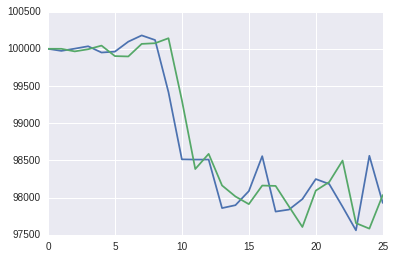

In [557]:
%matplotlib inline
asset = ASSET(df_test)
ans = asset.new_make_order()
daqidaluo = ans[0]
xiaoqixiaoluo = ans[1]
plt.plot(xiaoqixiaoluo)
plt.plot(daqidaluo)

In [424]:
#%%writefile backtest.py
class BACKTEST():
    
    def __init__(self, assetArr, benchmark=False):
        # transform the asset array to return array
        self._assetArr = assetArr
        self.returnArr = np.diff(assetArr) / assetArr[:-1]

    def return_(self):
        return (self._assetArr[-1] - self._assetArr[0]) / self._assetArr[0]

    def daily_return(self, P):
        diff = np.diff(P)
        return diff / P[:-1]

    def max_drawdown(self, P):
        diff = -np.diff(P) 
        return np.max(diff / P[:-1])

    def benchmark_annual_return(self, mStart, mEnd):
        return ((mEnd - mStart) / mStart)

    def annual_return(self, tr, n):
        return ((1 + tr) ** (250 / n)) - 1

    def algorithm_volatility(self, TR):
        return np.sqrt(np.var(TR) * 250)

    def benchmark_volatility():
        return

    def sharpe_ratio(self, tar, av, rfir=0.04):
        return (tar - rfir) / av

    def beta(self, TR, BR):
        return np.cov(TR, BR) / np.var(TR, BR)
        
    def alpha(self, tar, bar, beta, rfir=0.04):
        return tar - (beta * (bar - rfir) + rfir)

    def downside_risk(self, TAR, n):
        TAR_down = TAR[TAR < np.mean(TAR)]
        m = len(TAR_down)
        return np.sqrt(np.var(TAR_down, np.mean(TAR)) * 250)
        
    def sortino(self, tar, rfir, dr):
        return (tar - rfir) / dr
        
    def information_ratio(self, tar, bar, TR, BR):
        return (tar - bar) / np.std(TR - BR)

    # one stock
    def implement_backtest(self):

        totReturn = np.sum(self.returnArr)
        maxDrawdown = self.max_drawdown(self._assetArr)
        algoVola = self.algorithm_volatility(self.returnArr)
        totAnnReturn = self.annual_return(totReturn, len(self._assetArr)-1)
        sharpeRat = round(self.sharpe_ratio(totAnnReturn, algoVola), 10)
        print ("total return: {0}\nmax drawdown: {1}\nalgorithm volatility: {2}\nannualized return: {3}\nsharpe ratio: {4}"\
                .format(totReturn, maxDrawdown, algoVola, totAnnReturn, sharpeRat))

In [569]:
back = BACKTEST(np.array([100000, 100039.00, 100079, 99934, 99800]))#(xiaoqixiaoluo)
#back.implement_backtest()

In [559]:
back.algorithm_volatility(np.array([100000, 99972.00, 100002.00, 100034, 99950]))

452.28309718582233

In [415]:
back.sharpe_ratio(0.0395, 0.009)

-0.05555555555555561

In [565]:
def alvo(TR):
    ave = np.average(TR)
    return np.sqrt(np.sum(np.power((TR - ave), 2)) * 250 / (len(TR)-1))

In [570]:
alvo(back.returnArr)

0.016353474314102855

In [281]:
test = BACKTEST(daqidaluo)
test.annual_return(0.0006, 6)

0.025307433764397702

In [65]:
def return_(mStart, mEnd):
    return (mEnd - mStart) / mStart

def daily_return(P):
    diff = np.diff(P)
    return diff / P[:-1]

def max_drawdown(P):
    diff = -np.diff(P) 
    return np.max(diff / P[:-1])

def benchmark_annual_return(mStart, mEnd):
    return ((mEnd - mStart) / mStart)

def annual_return(tr, n):
    return (1 + tr) ** (250 / n) - 1

def algorithm_volatility(TR):
    return np.sqrt(np.var(TR) * 250)

def benchmark_volatility():
    return

def sharpe_ratio(tar, av, rfir=0.04):
    return (tar - rfir) / av

def beta(TR, BR):
    return np.cov(TR, BR) / np.var(TR, BR)
    
def alpha(tar, bar, beta, rfir=0.04):
    return tar - (beta * (bar - rfir) + rfir)

def downside_risk(TAR, n):
    TAR_down = TAR[TAR < np.mean(TAR)]
    m = len(TAR_down)
    return np.sqrt(np.var(TAR_down, np.mean(TAR)) * 250)
    
def sortino(tar, rfir, dr):
    return (tar - rfir) / dr
    
def information_ratio(tar, bar, TR, BR):
    return (tar - bar) / np.std(TR - BR)




In [138]:
s = buy_or_sell(Xtrain, Ydowntrain, Xtest)
s[:, 1] > 0.5

array([False, False,  True,  True, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
        True,  True,  True,  True, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False], dtype=bool)

In [140]:
s = buy_or_sell(Xtrain, Yuptrain, Xtest)
s[:, 1] > 0.5

array([False, False,  True,  True, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
        True,  True,  True,  True, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False], dtype=bool)

In [256]:
a = np.array([1,2,3])
b = np.array([1])
np.hstack((b, a))

array([1, 1, 2, 3])

In [202]:
def strategy(Xtest, upmsk, downmsk):
    # input: 
    buyin = upmsk.cumsum().values
    sellout = downmsk.cumsum().values
    # TODO: consider the case that the first sellout is before the first buyin
    orders = buyin - sellout
    #return orders
    orders[orders < 0] = 0
    orderNum = [n for n, g in groupby(orders) if n != 0]
    idx = np.where(orders)[0]
    shift_idx = np.where(np.diff(orders[idx])!=0)[0] + 1
    # [
    # array(2, 3, 4),
    # array(6,7),
    # index slice
    # ]
    orderIdx = np.split(idx, shift_idx)
    
    return (orderIdx, orderNum)

In [201]:
z = np.full((40), 0)
t = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,1,1,2,2,2,2,2,2,3,3,1,4,4])
t = orderIdx.values
idx = np.where(t)[0]
shift_idx = np.where(np.diff(t[idx])!=0)[0] + 1
np.split(idx, shift_idx)

/home/lcc/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(40, 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


[array([56]),
 array([57, 58, 59]),
 array([60, 61]),
 array([62, 63, 64, 65, 66, 67]),
 array([68, 69])]

In [459]:
date=df_y.iloc[-1].date
df_y[df_y.date==date]

,stock_id,date,high,low,open,close,up,down
136,000002,2015-12-18,24.43,21.7,22.4,24.43,NaN,NaN


In [277]:
dd = pd.DataFrame(np.full((6), 0))

/home/lcc/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(6, 0) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


In [424]:
np.tile(np.array([df_y.date.values[-1]], dtype=np.datetime64), 10)

array(['2015-12-18T08:00:00.000000000+0800',
       '2015-12-18T08:00:00.000000000+0800',
       '2015-12-18T08:00:00.000000000+0800',
       '2015-12-18T08:00:00.000000000+0800',
       '2015-12-18T08:00:00.000000000+0800',
       '2015-12-18T08:00:00.000000000+0800',
       '2015-12-18T08:00:00.000000000+0800',
       '2015-12-18T08:00:00.000000000+0800',
       '2015-12-18T08:00:00.000000000+0800',
       '2015-12-18T08:00:00.000000000+0800'], dtype='datetime64[ns]')

In [370]:
for i in dd.iterrows():
    print (i[0])

0
1
2
3
4
5


In [333]:
val = dd.apply(add111, axis=1).values
pro = np.random.random((6))
val * pro

/home/lcc/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(1, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/lcc/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(5, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/lcc/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(4, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/lcc/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future, full(3, 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)
/home/lcc/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:294: FutureWarning: in the future,

array([[ 0.        ,  0.02081869,  0.71234619,  0.31366329,  0.09000397,
         0.58916706],
       [ 0.        ,  0.02081869,  0.71234619,  0.31366329,  0.09000397,
                nan],
       [ 0.        ,  0.02081869,  0.71234619,  0.31366329,  0.09000397,
         0.58916706],
       [ 0.        ,  0.02081869,  0.71234619,  0.31366329,         nan,
                nan],
       [ 0.        ,  0.02081869,  0.71234619,         nan,         nan,
                nan],
       [ 0.        ,  0.02081869,  0.71234619,  0.31366329,  0.09000397,
                nan]])

In [243]:
def backtest(df, orderIdx, benchmark=False):
    # one stock
    # data frame in the test part
    # Index of the order
    maxDrawdown = 0
    totReturn = 0
    totDayReturn = np.array([])
    # for maxdrawdown, 
    for idxSlice in orderIdx:
        closeArr = df.loc[idxSlice, 'close'].values
        print (closeArr)
        drawdown = max_drawdown(closeArr)
        maxDrawdown = drawdown if maxDrawdown < drawdown else maxDrawdown
        # daily_return
        totDayReturn = np.append(totDayReturn, daily_return(closeArr))
        # return
        totReturn += return_(closeArr[0], closeArr[-1])
    if benchmark:
        print ('benchmark return: '+totReturn)
        return 0
    # measure algorithm_volatility, annual_return, shape_ratio
    algoVola = algorithm_volatility(totDayReturn)
    n = len(totDayReturn)
    totAnnReturn = annual_return(totReturn, n)
    orders = np.hstack(orderIdx)
    closeArr = df.loc[orders, 'close'].values
    sharpeRat = sharpe_ratio(totAnnReturn, algoVola)
    print ('total return: {0}\n\
            max drawdown: {1}\n\
            algorithm volatility: {2}\n\
            annualized return: {3}\n\
            sharpe ratio: {4}'\
            .format(totReturn, maxDrawdown, algoVola, totAnnReturn, sharpeRat))
    return 0

In [183]:
buyin = upmsk.cumsum()
sellout = downmsk.cumsum()
a = buyin - sellout


In [228]:
n

66

In [244]:
n = int(len(X) * 0.6)
Xtrain = X[:n]
Yuptrain = Yup[:n]
Ydowntrain = Ydown[:n]
Xtest = X[n:]
Yuptest = Yup[n:]
Ydowntest = Ydown[n:]

upmsk = df_y.loc[n:, 'up'] == 1# == 0#buy_or_sell(Xtrain, Yuptrain, Xtest)
downmsk = df_y.loc[n:, 'down'] == 1#buy_or_sell(Xtrain, Ydowntrain, Xtest)
upmsk = upmsk[:-1]
downmsk = downmsk[:-1]
orderIdx = strategy(df.iloc[n:], upmsk, downmsk)[0]
backtest(df_y[n:].reset_index(drop=True), orderIdx)

[ 15.07]


ValueError: zero-size array to reduction operation maximum which has no identity

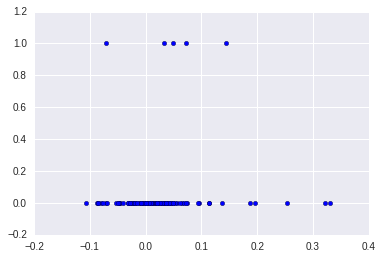

In [48]:

#fig = plt.figure()
#ax = fig.gca(projection='3d')
#ax.scatter(x1, x2, x3, c=color.T)
plt.scatter(x_4[:-1], Y)
#plt.scatter(x_2, label='x_2')
#plt.plot(x_3, label='x_3')
#plt.plot(x_4, label='x_4')
#plt.plot(Y, label='y')

In [514]:
def sample(X, y, k):
    # k1: number of orginal data
    # k: number of data to sample
    index = np.random.rand(len(X)) < (k / len(X))
    (X, y) = (X[index], y[index])
    return (X,y)

def log1pexp(x):
    # x: theta.T * X
    seed = 33.3
    y = np.copy(x)
    idx = x < seed
    y[idx] = np.log1p(np.exp(x[idx]))
    return y

def sigmoid(x):
    return np.exp(-log1pexp(-x))

def lr_llh(X, y, w, beta):
    n = X.shape[0]
    h = 2 * y - 1
    a = X @ w
    llh = -(np.sum(log1pexp(-h * a)) + 0.5 * beta * np.dot(w, w)) / n
    return llh

def lr_grad(X, y, w, beta):
    a = X @ w
    z = sigmoid(a)
    g = (z - y) @ X + beta * w
    return g

def lr_sgd(X, y, beta, a=0.1):
    n = X.shape[0]
    x0 = np.ones((n, 1))
    X = np.hstack((x0, X))
    d = X.shape[1]
    iter = 2000
    llh = np.full(iter, np.inf)
    w = np.zeros(d)
    for t in range(iter):
        #sample 100 data
        X_s, y_s = sample(X, y, 100)
        g = lr_grad(X_s, y_s, w, beta)
        w = w - a*g
        llh[t] = lr_llh(X_s, y_s, w, beta)
    return (w, llh)

def lr_gd(X, y, beta, a=0.1):
    n = X.shape[0]
    x0 = np.ones((n, 1))
    X = np.hstack((x0, X))
    d = X.shape[1]
    iter = 2000
    llh = np.full(iter, np.inf)
    w = np.zeros(d)
    for t in range(iter):
        g = lr_grad(X, y, w, beta)
        w = w - a*g
        llh[t] = lr_llh(X, y, w, beta)
    return (w, llh)

array([ -8.31488662e+03,  -2.30664346e+04,  -4.46922489e+04, ...,
        -2.58947938e+09,  -2.59029039e+09,  -2.59110071e+09])

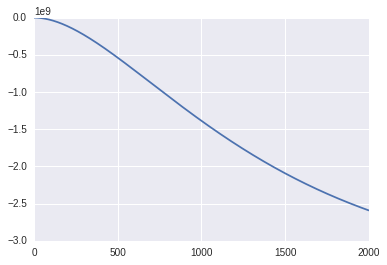

In [533]:
beta = 1e-2

(w, llh) = lr_gd(X, y, beta)
plt.plot(llh)
llh

# test complex before right 

In [1015]:
def check_C_O_diff(O_mrng, C_nght):
    return (O_mrng - C_nght)/ C_nght

In [755]:
stockGp = df_copy.groupby('stock_id')
closeList = []
openList = []
dateList = []
for stockId, stock in stockGp:
    print (stockId)
    dateGp = stock.groupby('date')
    closeVals = np.array([])
    openVals = np.array([])
    dates = np.array([])
    for date, group in dateGp:
        # no deal that day:
        if group['open'].max() <= 0:
            continue
        #print (group)
        newest = group[group['open'] > 0].iloc[0]
        latest = group[group['close'] > 0].iloc[-1]
        O_mrng = newest['open']
        C_nght = latest['close']
        #print (C_nght, O_mrng)
        closeVals = np.append(closeVals, C_nght)
        openVals = np.append(openVals, O_mrng)
        dates = np.append(dates, date)
    closeList.append(closeVals)
    openList.append(openVals)
    dateList.append(dates)

000002
000004
000005
000006
000099


In [611]:
with open('diff.txt', 'w+') as f:
    for i in range(len(diff)):
        f.write(str(diff[i])+' '+str(dates[i]).split()[0]+"~"+str(dates[i+1]).split()[0]+'\n')

In [1]:
import asset

NameError: name 'df' is not defined